In [1]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn import svm, tree, neural_network
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [3]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "v5": "GM Visual cortex V5"
        }


In [4]:
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12', '13', '14', '15', '16', '17', '18', '19']

In [8]:
svm_predictions = []
dec_tree_predictions = []
knn_predictions = []
mlp_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():

        for run in range(1, 11):
            X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'move' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
            #mean_image = image.mean_img(all_images)
            #mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
            #mean_centered = all_images

            #for i, key in enumerate(np.sort(list(z_maps.keys()))):

                #z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            #X.append(fmri_masked)
            #X_test.append(fmri_masked[1::2])

            #X = np.concatenate(X)
            X = fmri_masked
            y = np.tile(np.repeat(['153', '207', '45', '99'], 5), 1)
            svm_predictions.append(cross_val_predict(OneVsRestClassifier(svm.SVC(probability = True)), X, y, cv=5, method='predict_proba'))
            dec_tree_predictions.append(cross_val_predict(tree.DecisionTreeClassifier(max_depth=4), X, y, cv=5, method='predict_proba'))
            knn_predictions.append(cross_val_predict(OneVsRestClassifier(KNeighborsClassifier()), X, y, cv=5, method='predict_proba'))
            #mlp_predictions.append(cross_val_predict(neural_network.MLP(), X, y, cv=10, method='predict_proba'))

        print("Mask done: ", mask)
    print('Subject done:', subject_id)



Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done

In [9]:
knn_predictions = np.concatenate(knn_predictions)


In [12]:
dec_tree_predictions = np.concatenate(dec_tree_predictions)


In [14]:
svm_predictions = np.concatenate(svm_predictions)

In [22]:
np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 10), 5 * len(masks.keys())), len(subject_list)).shape

(10800,)

In [31]:
within_knn_predictions_df = pd.DataFrame({'153_prob': knn_predictions[:, 0], 
                               '207_prob': knn_predictions[:, 1],
                               '45_prob': knn_predictions[:, 2],
                               '99_prob': knn_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*20), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 20), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 10*len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 20), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*10*len(masks.keys()))
                              })

In [24]:
within_dec_tree_predictions_df = pd.DataFrame({'153_prob': dec_tree_predictions[:, 0], 
                               '207_prob': dec_tree_predictions[:, 1],
                               '45_prob': dec_tree_predictions[:, 2],
                               '99_prob': dec_tree_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*20), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 20), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 10* len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 20), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*10*len(masks.keys()))
                              })

In [25]:
within_svm_predictions_df = pd.DataFrame({'153_prob': svm_predictions[:, 0], 
                               '207_prob': svm_predictions[:, 1],
                               '45_prob': svm_predictions[:, 2],
                               '99_prob': svm_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 10*20), len(subject_list)),
                               'run': np.tile(np.tile(np.repeat(np.arange(1, 11), 20), len(masks.keys())), len(subject_list)), 
                               'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 10* len(masks.keys())), len(subject_list)),
                               'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 20), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*10*len(masks.keys()))
                              })

In [13]:
within_predictions_df = pd.read_csv('all_way_within_pred.csv').drop('Unnamed: 0', axis = 1)
within_predictions_df_melt = within_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [35]:
within_knn_predictions_df_melt = within_knn_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')
within_dec_tree_predictions_df_melt = within_dec_tree_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')
within_svm_predictions_df_melt = within_svm_predictions_df.melt(id_vars=['Subject_id', 'dir_x_rest', 'ROIs', 'run', 'block_type'], var_name='dirs', value_name='probs')


In [27]:
within_svm_predictions_df.to_csv('svm_within_mov_pred.csv')

In [33]:
within_knn_predictions_df.to_csv('knn_within_mov_pred.csv')

In [29]:
within_dec_tree_predictions_df.to_csv('dec_tree_mov_within_pred.csv')

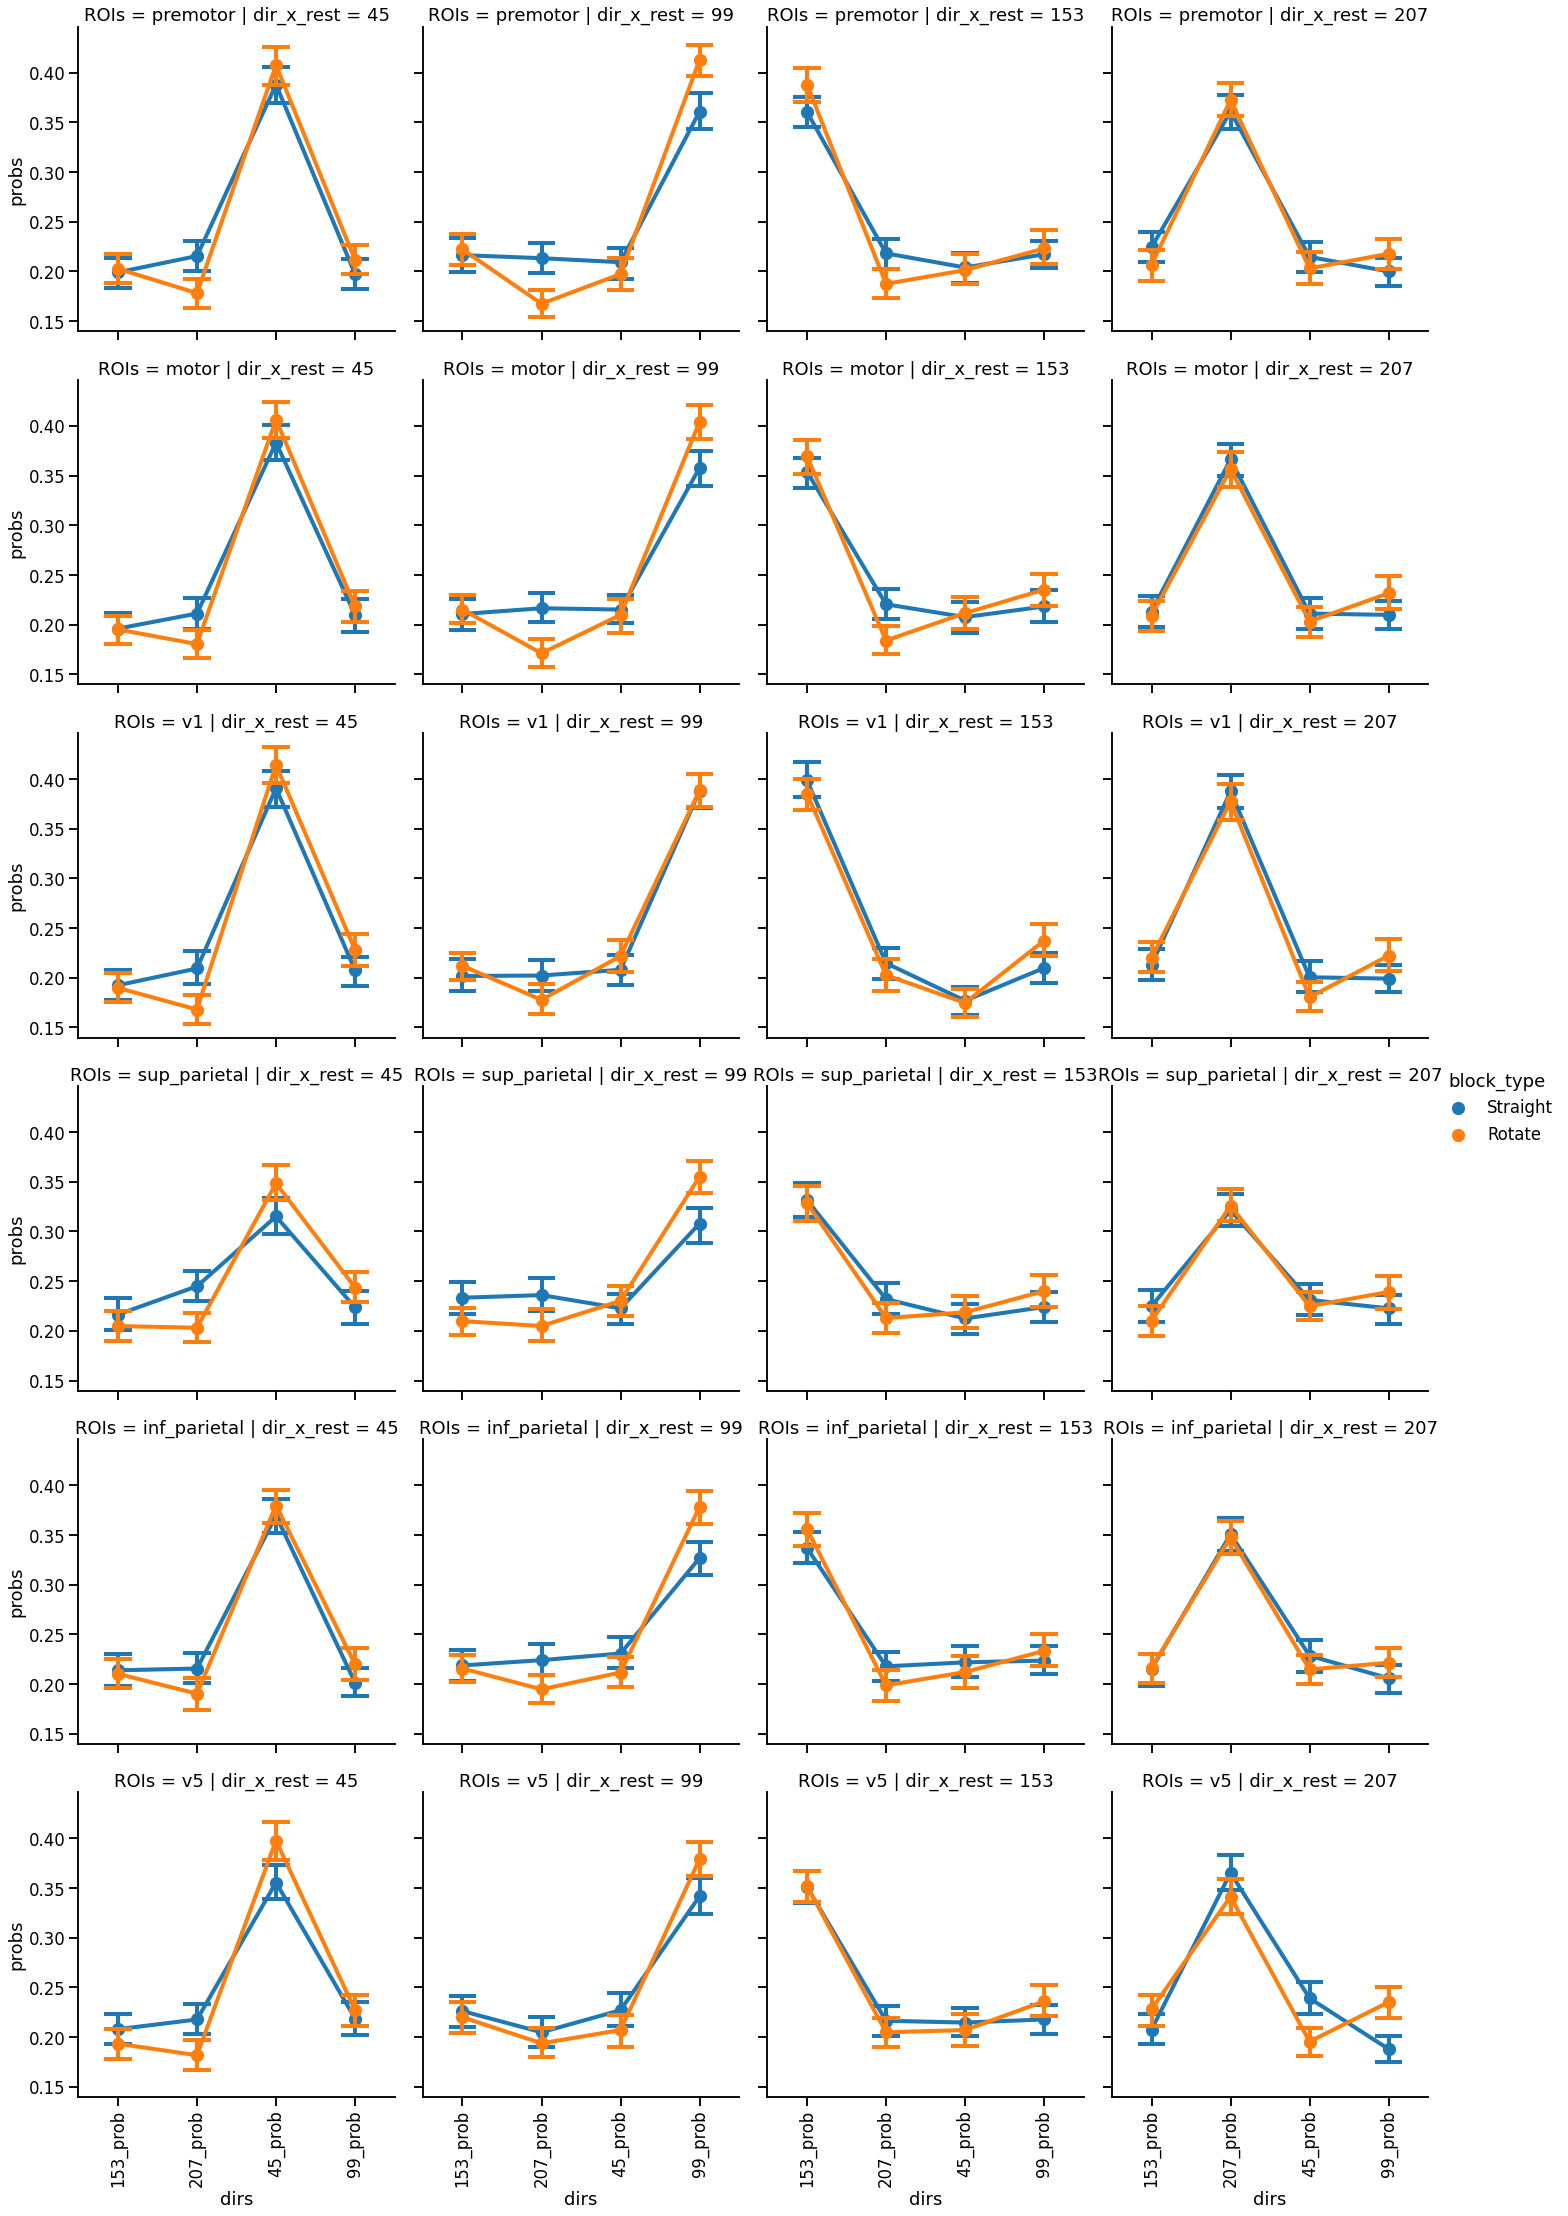

In [36]:
sns.set_context('talk')
ax = sns.catplot(x = 'dirs', y = 'probs', col = 'dir_x_rest', 
            hue = 'block_type', row = 'ROIs', 
            data = within_knn_predictions_df_melt, kind = 'point', capsize = 0.3)
ax.set_axis_labels().set_xticklabels(rotation = 90)


In [38]:
svm_predictions = []
knn_predictions = []
dec_tree_predictions = []
nn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():
        X = []
        X_test = []
        for run in range(1, 11):
            #X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'move' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
            #mean_image = image.mean_img(all_images)
            #mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
            #mean_centered = all_images

            #for i, key in enumerate(np.sort(list(z_maps.keys()))):

                #z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            #X.append(fmri_masked)
            #X_test.append(fmri_masked[1::2])

            #X = np.concatenate(X)
            if run%2 != 0:
                X.append(fmri_masked)
                #y = np.repeat(['153', '207', '45', '99'], 10)
                #clf_svm = OneVsRestClassifier(svm.SVC(probability = True))                
                #clf_svm.fit(X, y)
                #clf_knn = OneVsRestClassifier(KNeighborsClassifier())                
                #clf_knn.fit(X, y)
                #clf_dec_tree = OneVsRestClassifier(tree.DecisionTreeClassifier())                
                #clf_dec_tree.fit(X, y)
                
                
            else:
                X_test.append(fmri_masked)
                #y_test = np.repeat(['153', '207', '45', '99'], 10)
                
                #svm_predictions.append(clf_svm.predict_proba(X_test))
                #knn_predictions.append(clf_knn.predict_proba(X_test))
                #dec_tree_predictions.append(clf_dec_tree.predict_proba(X_test))
                
                
        X = np.concatenate(X)
        X_test = np.concatenate(X_test)
        y = np.tile(np.repeat(['153', '207', '45', '99'], 5), 5)
        #y_test = np.tile(np.repeat(['153', '207', '45', '99'], 10), 5)
            
        clf = OneVsRestClassifier(svm.SVC(probability = True))
        clf.fit(X, y)
        svm_predictions.append(clf.predict_proba(X_test))
        
        clfk = OneVsRestClassifier(KNeighborsClassifier())
        clfk.fit(X, y)
        knn_predictions.append(clfk.predict_proba(X_test))
        
        clft = OneVsRestClassifier(tree.DecisionTreeClassifier())
        clft.fit(X, y)
        dec_tree_predictions.append(clft.predict_proba(X_test))
        
        clfnn = neural_network.MLPClassifier(learning_rate='adaptive')
        clfnn.fit(X, y)
        #clfnn_predictions.append(clfnn.predict_proba(X_test))
        
        print("Mask done: ", mask)
    print('Subject done:', subject_id)



/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 01


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 02


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 03


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 04


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 05


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 06


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 07


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 08


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 09


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 11


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 12


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 13


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 14


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 15


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 16


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 17


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v5
Subject done: 18


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  premotor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  motor


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  v1


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  sup_parietal


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Mask done:  inf_parietal
Mask done:  v5
Subject done: 19


/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [39]:
svm_predictions = np.concatenate(svm_predictions)
knn_predictions = np.concatenate(knn_predictions)
dec_tree_predictions = np.concatenate(dec_tree_predictions)
#Temp


In [40]:
#clfnn_predictions = np.concatenate(clfnn_predictions)

In [41]:
between_svm_predictions_df = pd.DataFrame({'153_prob': svm_predictions[:, 0], 
                               '207_prob': svm_predictions[:, 1],
                               '45_prob': svm_predictions[:, 2],
                               '99_prob': svm_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*20), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 20), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),

                              })

In [42]:
between_knn_predictions_df = pd.DataFrame({'153_prob': knn_predictions[:, 0], 
                               '207_prob': knn_predictions[:, 1],
                               '45_prob': knn_predictions[:, 2],
                               '99_prob': knn_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*20), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 20), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),

                              })

In [43]:
between_dec_tree_predictions_df = pd.DataFrame({'153_prob': dec_tree_predictions[:, 0], 
                               '207_prob': dec_tree_predictions[:, 1],
                               '45_prob': dec_tree_predictions[:, 2],
                               '99_prob': dec_tree_predictions[:, 3],
                               'ROIs': np.tile(np.repeat(list(masks.keys()), 5*20), len(subject_list)),
                               'run_pairs': np.tile(np.tile(np.repeat(np.arange(1, 6), 20), len(masks.keys())), len(subject_list)), 
                               'rotate_dir': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),
                               #'block_type': np.tile(np.tile(np.repeat(['Straight', 'Rotate'], 40), 5 * len(masks.keys())), len(subject_list)),
                               'Subject_id': np.repeat(subject_list, 20*5*len(masks.keys())),
                              'dir_x_rest': np.tile(np.tile(np.repeat([153, 207, 45, 99], 5), 5* len(masks.keys())), len(subject_list)),

                              })

In [44]:
between_svm_predictions_df_melt = between_svm_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
between_knn_predictions_df_melt = between_knn_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
between_dec_tree_predictions_df_melt = between_dec_tree_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')
#between_clfnn_predictions_df_melt = between_clfnn_predictions_df.melt(id_vars=['dir_x_rest', 'Subject_id', 'rotate_dir', 'ROIs', 'run_pairs'], var_name='dirs', value_name='probs')


In [45]:
between_svm_predictions_df.to_csv('svm_between_mov_pred.csv')
between_knn_predictions_df.to_csv('knn_between_mov_pred.csv')
between_dec_tree_predictions_df.to_csv('dec_tree_between_mov_pred.csv')
#between_clfnn_predictions_df.to_csv('all_way_dec_tree_between_pred.csv')


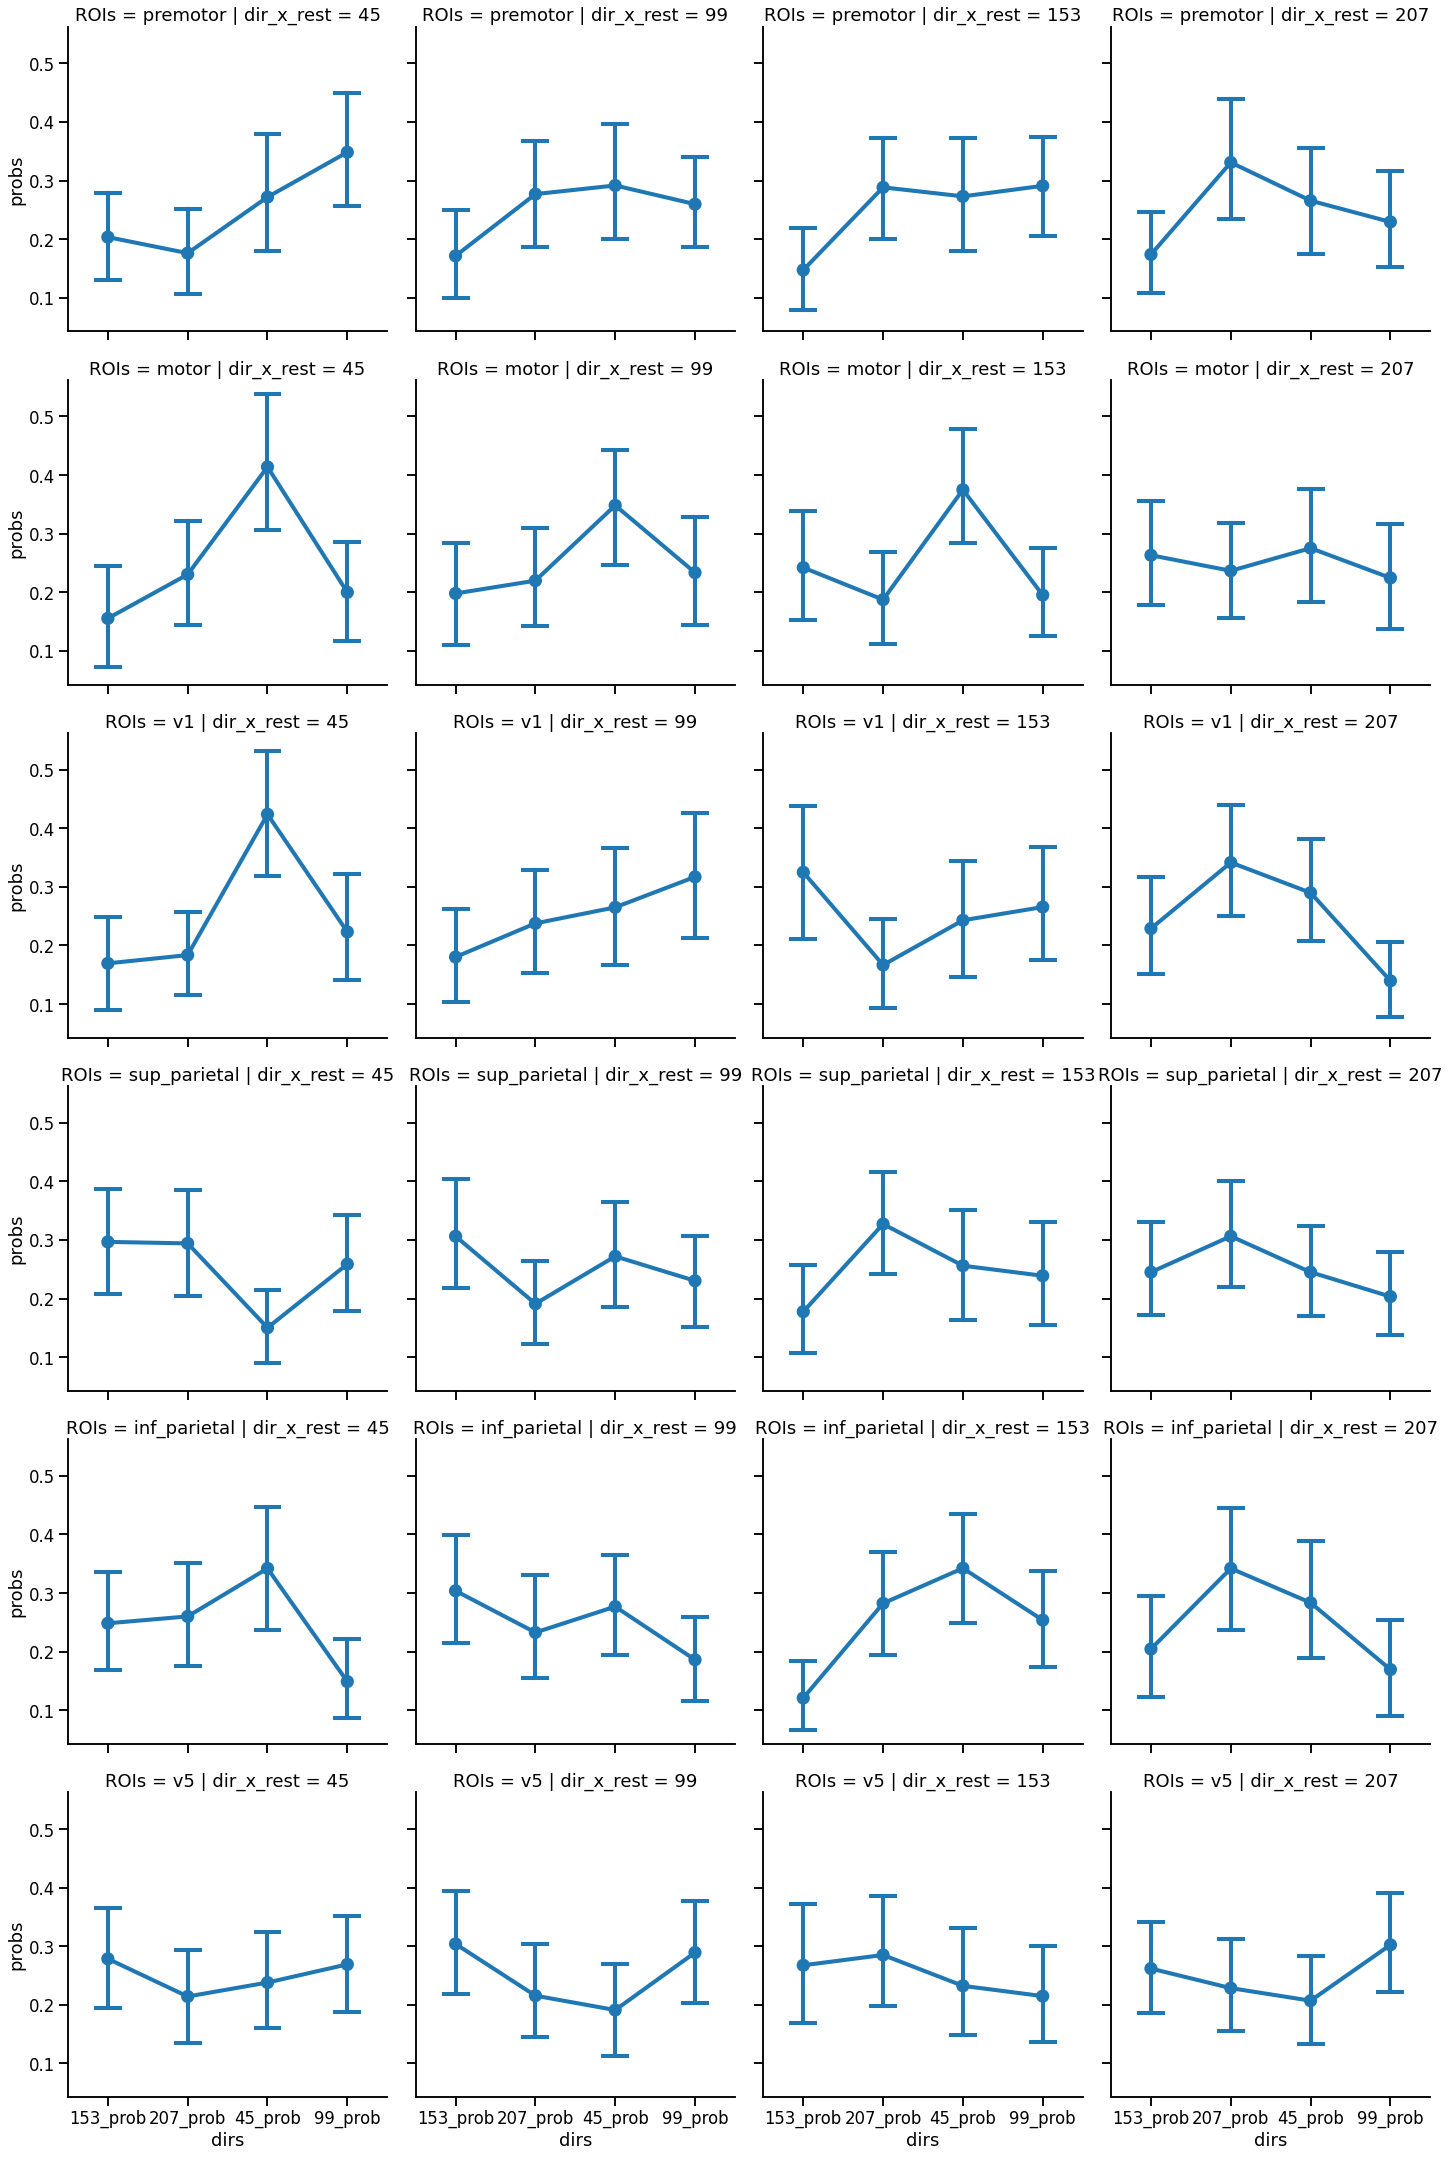

In [47]:

sns.set_context('talk')
ax = sns.catplot(x = 'dirs', y = 'probs', 
            col = 'dir_x_rest', row = 'ROIs',
            data = between_dec_tree_predictions_df_melt[between_dec_tree_predictions_df_melt.run_pairs == 1], kind = 'point', capsize = 0.3)
#ax.set_axcd is_labels().set_xticklabels(rotation = 90)


In [48]:
svm_predictions = []
knn_predictions = []
dec_tree_predictions = []
mlp_coefs = []
mlp_4h_coefs = []
#clfnn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():
        X = []
        X_test = []
        for run in range(1, 11):
            #X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'move' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
            X.append(fmri_masked)
                
                
        X = np.concatenate(X)
        y = np.tile(np.repeat(['straight', 'rotate'], 20), 5)
        sv = svm.SVC()
        sv.fit(X, y)
        mlp_4h_coefs.append(sv.coefs_)
        
        print("Mask done: ", mask)
    print('Subject done:', subject_id)



Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done

In [61]:
sv.coefs_[1].shape

(100, 1)

In [49]:
svm_predictions = []
knn_predictions = []
dec_tree_predictions = []
mlp_coefs_45_v_rest = []
mlp_4h_coefs_45_v_rest = []
#clfnn_predictions = []
for subject_id in subject_list:
    for mask in masks.keys():
        X = []
        X_test = []
        for run in range(1, 11):
            #X = []
            run_no = str(run).zfill(2)
            beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
            run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

            z_maps = {}

            for i in run_beta_maps:
                if 'move' in i:
                    z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

            #Sorted by first number
            all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, all_images, interpolation='nearest')

            fmri_masked = masking.apply_mask(all_images, mask_img=resampled_mask)
                
            if run%2 != 0:            
                X.append(fmri_masked)
        X = np.concatenate(X)
        y = np.tile(np.concatenate([np.repeat('not_45', 10), np.repeat('45', 5), np.repeat('not_45', 5)]), 5)
        sv = neural_network.MLPClassifier(hidden_layer_sizes=(100, 40, 20, 10))
        sv.fit(X, y)
        mlp_4h_coefs_45_v_rest.append(sv.coefs_)
        #coefs.append(svm.SVC(kernel='linear').fit(X, y).coef_)
            
        print("Mask done: ", mask)
    print('Subject done:', subject_id)



Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 01
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 02
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 03
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 04
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 05
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 06
Mask done:  premotor
Mask done:  motor
Mask done:  v1
Mask done:  sup_parietal
Mask done:  inf_parietal
Mask done:  v5
Subject done: 07
Mask done:  premotor
Mask done:  motor
Mask done

In [60]:
len(mlp_4h_coefs)

108

In [61]:
mlp_coef_corrs = []
coef_corrs = []
mlp_4h_coef_corrs = []
mlp_l1_coef_corrs = []
mlp_l2_coef_corrs = []
mlp_l3_coef_corrs = []
mlp_l4_coef_corrs = []

for i in range(len(mlp_4h_coefs)):
    #coef_corrs.append(stat.pearsonr(coefs[i][0], coefs_45_v_rest[i][0]))
    #mlp_coef_corrs.append(stat.pearsonr(mlp_coefs[i][1][:, 0], mlp_coefs_45_v_rest[i][1][:, 0]))
    mlp_l1_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 1], mlp_4h_coefs_45_v_rest[i][1][:, 1]))
    mlp_l2_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 2], mlp_4h_coefs_45_v_rest[i][1][:, 2]))
    mlp_l3_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 3], mlp_4h_coefs_45_v_rest[i][1][:, 3]))
    mlp_l4_coef_corrs.append(stat.pearsonr(mlp_4h_coefs[i][1][:, 4], mlp_4h_coefs_45_v_rest[i][1][:, 4]))
    

In [62]:
#arr_coef_corrs = np.concatenate(coef_corrs).reshape(6*18, 2)
#mlp_arr_coef_corrs = np.concatenate(mlp_coef_corrs).reshape(6*18, 2)
mlp_l1_arr_coef_corrs = np.concatenate(mlp_l1_coef_corrs).reshape(6*18, 2)
mlp_l2_arr_coef_corrs = np.concatenate(mlp_l2_coef_corrs).reshape(6*18, 2)
mlp_l3_arr_coef_corrs = np.concatenate(mlp_l3_coef_corrs).reshape(6*18, 2)
mlp_l4_arr_coef_corrs = np.concatenate(mlp_l4_coef_corrs).reshape(6*18, 2)


In [64]:
df = pd.DataFrame({'participant_id': np.repeat(subject_list, 6), 
                   'masks': np.tile(list(masks.keys()), len(subject_list)),
                   'l1': mlp_l1_arr_coef_corrs[:, 0],
                   'l2': mlp_l2_arr_coef_corrs[:, 0],
                   'l3': mlp_l3_arr_coef_corrs[:, 0],
                   'l4': mlp_l4_arr_coef_corrs[:, 0],

                   #'mlp_4h_corr_pval': mlp_4h_arr_coef_corrs[:, 1],
                   #'svm_corr_coef': arr_coef_corrs[:, 0],
                   #'svm_corr_pval': arr_coef_corrs[:, 1]
                  })

In [ ]:
df.to_csv('mlp_45_rotstr_corrs_mov.csv')

In [65]:
df_melt = df.melt(id_vars=['participant_id', 'masks'], var_name='layers', value_name='corr')

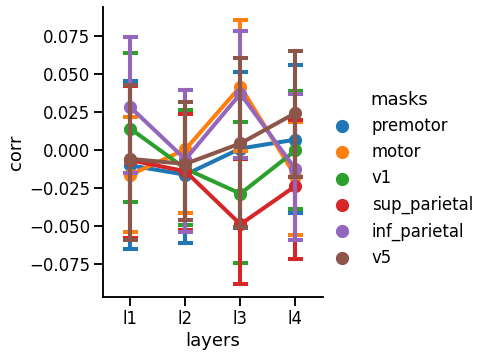

In [66]:
sns.catplot(x = 'layers', y = 'corr', hue = 'masks', data = df_melt, kind = 'point', capsize = 0.2)